# treeArches: identifying new cell types (advanced tutorial)

In this more advanced tutorial, we will show how to use a reference atlas and corresponding cell type hierarchy to detect new cell types in your query dataset. Here, we assume that the query dataset is labeled. If the query dataset is unlabeled, you can just predict the labels of the cells (see previous basic tutorial) and check which cells are rejected. Here, we'll focus more on complete cell types or clusters instead of individual cells.

In this tutorial we'll show two ways to detect new (sub)types:
- Option 1: detecting a complete new cell type. We will update the reference cell type hierarchy with the query labels. A new cell type is detected if a cell type from the query is not matched to a cell type in the reference hierarchy.
- Option 2: detecting a new subtype. Sometimes a query cell type matches a cell type in the hierarchy, but still a lot of cells are rejected. This could indicate that part of that query cell type is a different subtype that is not detected yet. We will show that you can detect this by comparing the updated hierarchy to the predictions made.


In [1]:
import scanpy as sc
import scHPL
import numpy as np
import pickle
import time as tm
import copy as cp
import pandas as pd
import matplotlib
import seaborn as sns

In [2]:
sc.settings.set_figure_params(dpi=1000, frameon=False)
sc.set_figure_params(dpi=1000)
sc.set_figure_params(figsize=(7,7))

matplotlib.rcParams['pdf.fonttype'] = 42

## Load reference and cell type hierarchy

In this tutorial, we will use the human lung cell atlas (HLCA) as reference. The embeddings for the reference and IPF (query) data we use, can be downloaded [here](https://zenodo.org/record/6337966#.YqrznidBx3h). These embeddings were created with scArches. The trained classifier can be downloaded from [Zenodo](https://doi.org/10.5281/zenodo.6786357). There are two classifier here: one trained with the FAISS library and one without. The FAISS library makes the model faster but only works on Linux and with a gpu. More information about installation can be found [here](https://anaconda.org/pytorch/faiss-gpu).

If you want to train the classifier for the cell type hierarchy yourself, you can find a tutorial [here](https://github.com/lcmmichielsen/treeArches-reproducibility/blob/main/Figure2-HLCA%20healthy/Figure2%2C%20S3-5.ipynb).





In [3]:
LCA = sc.read('HLCA_emb_and_metadata.h5ad')
file_to_read = open("tree_HCLA_FAISS_withRE.pickle", "rb")
HLCA_tree = pickle.load(file_to_read)
file_to_read.close()


## Load query embedding and annotations

We will use a dataset consisting of healthy and IPF (Idiopathic Pulmonary Fibrosis) cells as query dataset. The query embeddings can be downloaded [here](https://zenodo.org/record/6337966#.YqrznidBx3h). The data with annotations can be downloaded [here](https://doi.org/10.5281/zenodo.6786357).

In [4]:
emb_ipf = sc.read('HLCA_extended_models_and_embs/surgery_output_embeddings/Sheppard_2020_emb_LCAv2.h5ad')

In [5]:
data_IPF = sc.read('Sheppard_2020_noSC_finalAnno.h5ad')

## Updating the cell type hierarchy

Before we can update the cell-type hierarchy. We have to preprocess the reference and query embeddings a bit. First, we concatenate the cell type labels with the condition labels. This way, we ensure that we can differentiate between the healthy and IPF cells.



In [6]:
data_IPF.obs['ct-batch'] = np.char.add(np.char.add(np.array(data_IPF.obs['anno_final'], dtype=str), '-'), np.array(data_IPF.obs['condition']))

Prepare query embeddings

In [35]:
emb_ipf = emb_ipf[data_IPF.obs_names]
emb_ipf.obs['ct-batch'] = data_IPF.obs['ct-batch']
emb_ipf.obs['batch'] = 'Query'
emb_ipf.obs['batch2'] = data_IPF.obs['condition']

/tmp/ipykernel_2427513/1399860873.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  emb_ipf.obs['ct-batch'] = data_IPF.obs['ct-batch']


Prepare reference embeddings

In [36]:
LCA.obs['ct-batch'] = LCA.obs['ann_finest_level']
LCA.obs['batch'] = 'Reference'
LCA.obs['batch2'] = 'Reference'

Concatenate the reference and query data

In [37]:
LCA_IPF = sc.concat([LCA, emb_ipf])
LCA_IPF.obs['ct-batch'] = LCA_IPF.obs['ct-batch'].str.replace('_',' ')

Remove cell types that are smaller than 10 cells from the data. 

In [38]:
xx = LCA_IPF.obs.groupby(['ct-batch']).count()
cp_toremove = xx[xx['batch'] < 10].index
idx_tokeep = np.isin(LCA_IPF.obs['ct-batch'], cp_toremove) == False
LCA_IPF = LCA_IPF[idx_tokeep]
LCA_IPF


View of AnnData object with n_obs × n_vars = 646445 × 30
    obs: 'ct-batch', 'batch', 'batch2'

Before updating the hierarchy, we subsample the data (otherwise it takes long to run) and make a UMAP. 

In [39]:
LCA_IPF_subs = sc.pp.subsample(LCA_IPF, fraction=0.25, copy=True)

sc.pp.neighbors(LCA_IPF_subs)
sc.tl.leiden(LCA_IPF_subs)
sc.tl.umap(LCA_IPF_subs)


In the UMAP, we can for instance see where the healthy and IPF cells are with respect to the reference

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


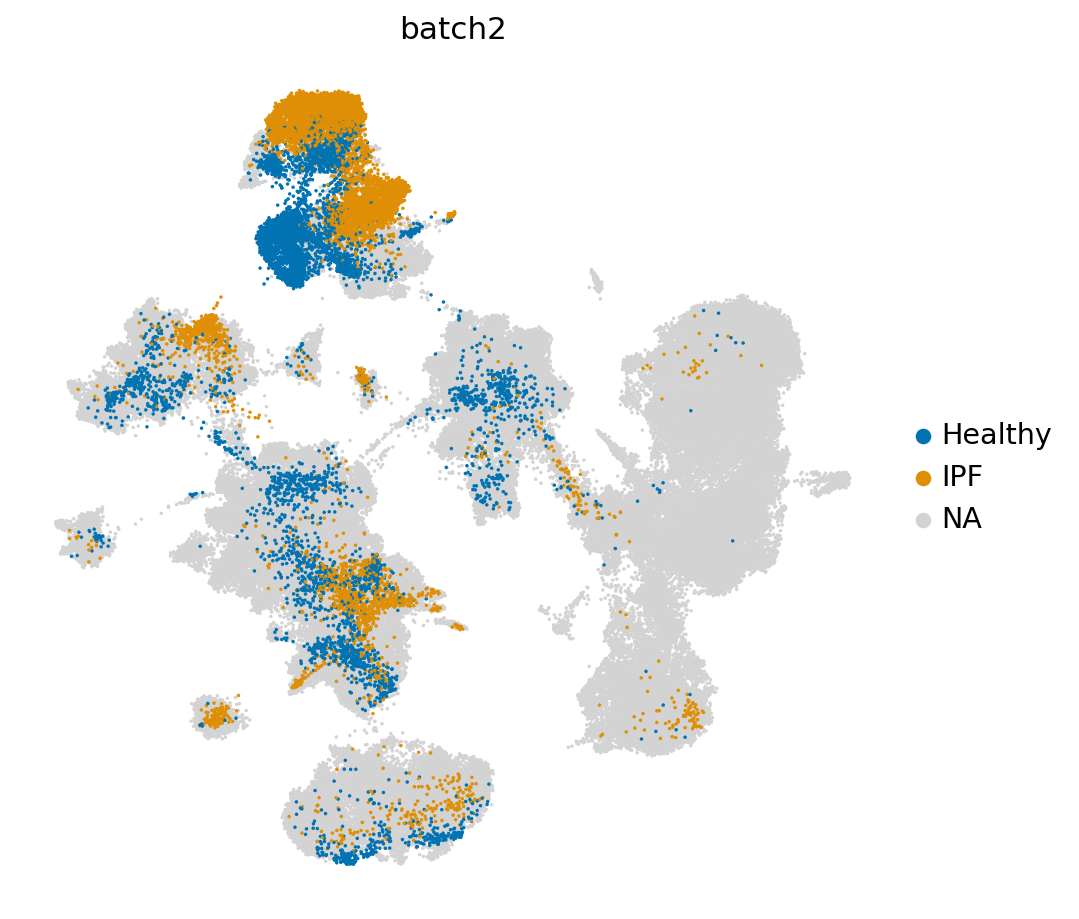

In [40]:
sc.pl.umap(LCA_IPF_subs,
           color=['batch2'], groups = ['Healthy', 'IPF'],
           frameon=False,
           wspace=0.6, s=10, palette=sns.color_palette('colorblind', as_cmap=True)
           )


The reference data contains many cell types. Therefore, we visualize the second annotation level here instead of the most detailed level. 

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


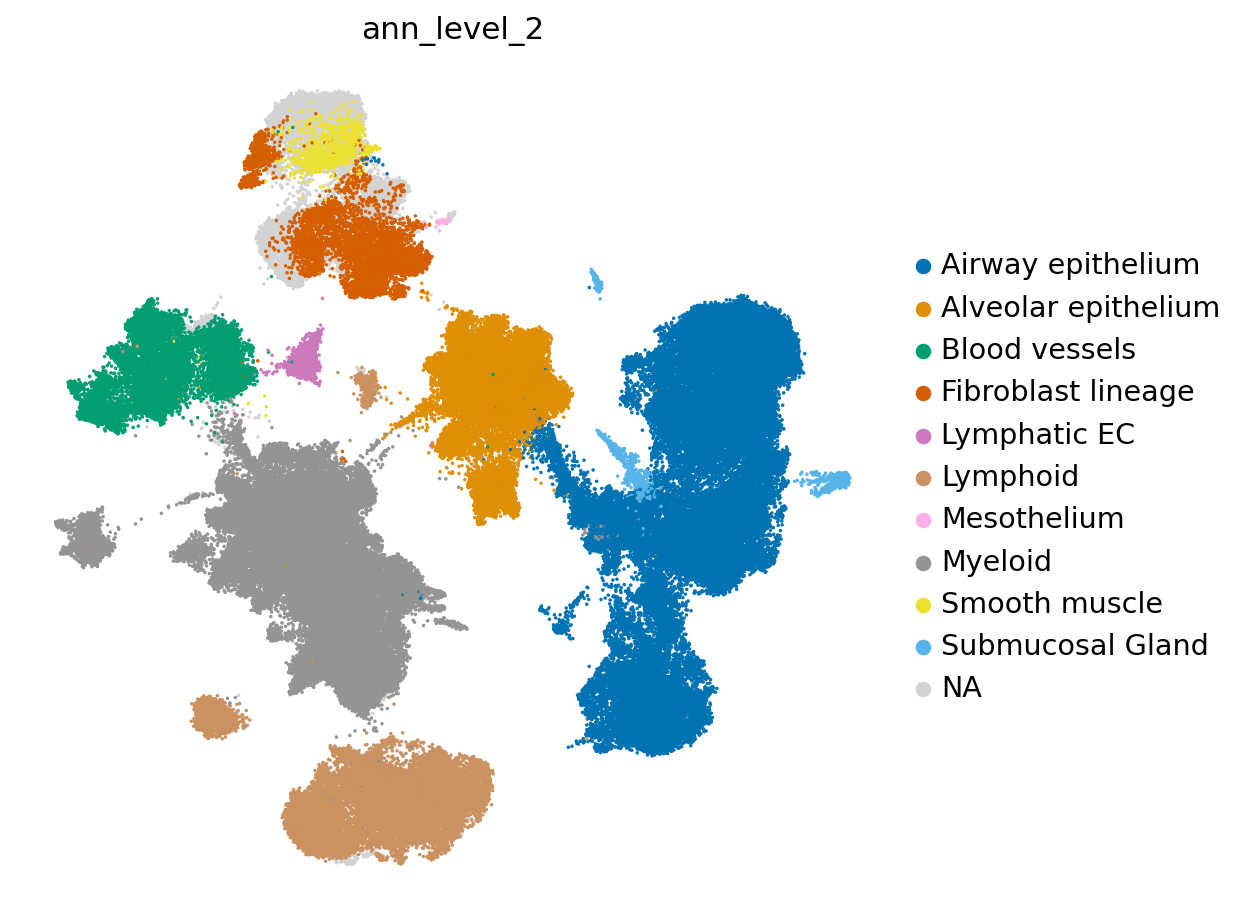

In [43]:
LCA_IPF_subs.obs['ann_level_2'] = LCA.obs.ann_level_2

sc.pl.umap(LCA_IPF_subs, color=['ann_level_2'], 
           groups = ['Airway epithelium', 'Alveolar epithelium', 
                     'Blood vessels', 'Fibroblast lineage', 'Lymphatic EC', 
                     'Lymphoid', 'Mesothelium', 'Myeloid', 'Smooth muscle',
                     'Submucosal Gland'],
           frameon=False,
           wspace=0.6, s=10, palette=sns.color_palette('colorblind', as_cmap=True)
           )


Update the cell type hierarchy with the query cell types. In the updated hierarchy, we see that for instance the 'Transitioning epithelial cells' are added as a new cell type to the tree. This cell type was indeed not in the reference and thus correctly discovered as new.

Starting tree:


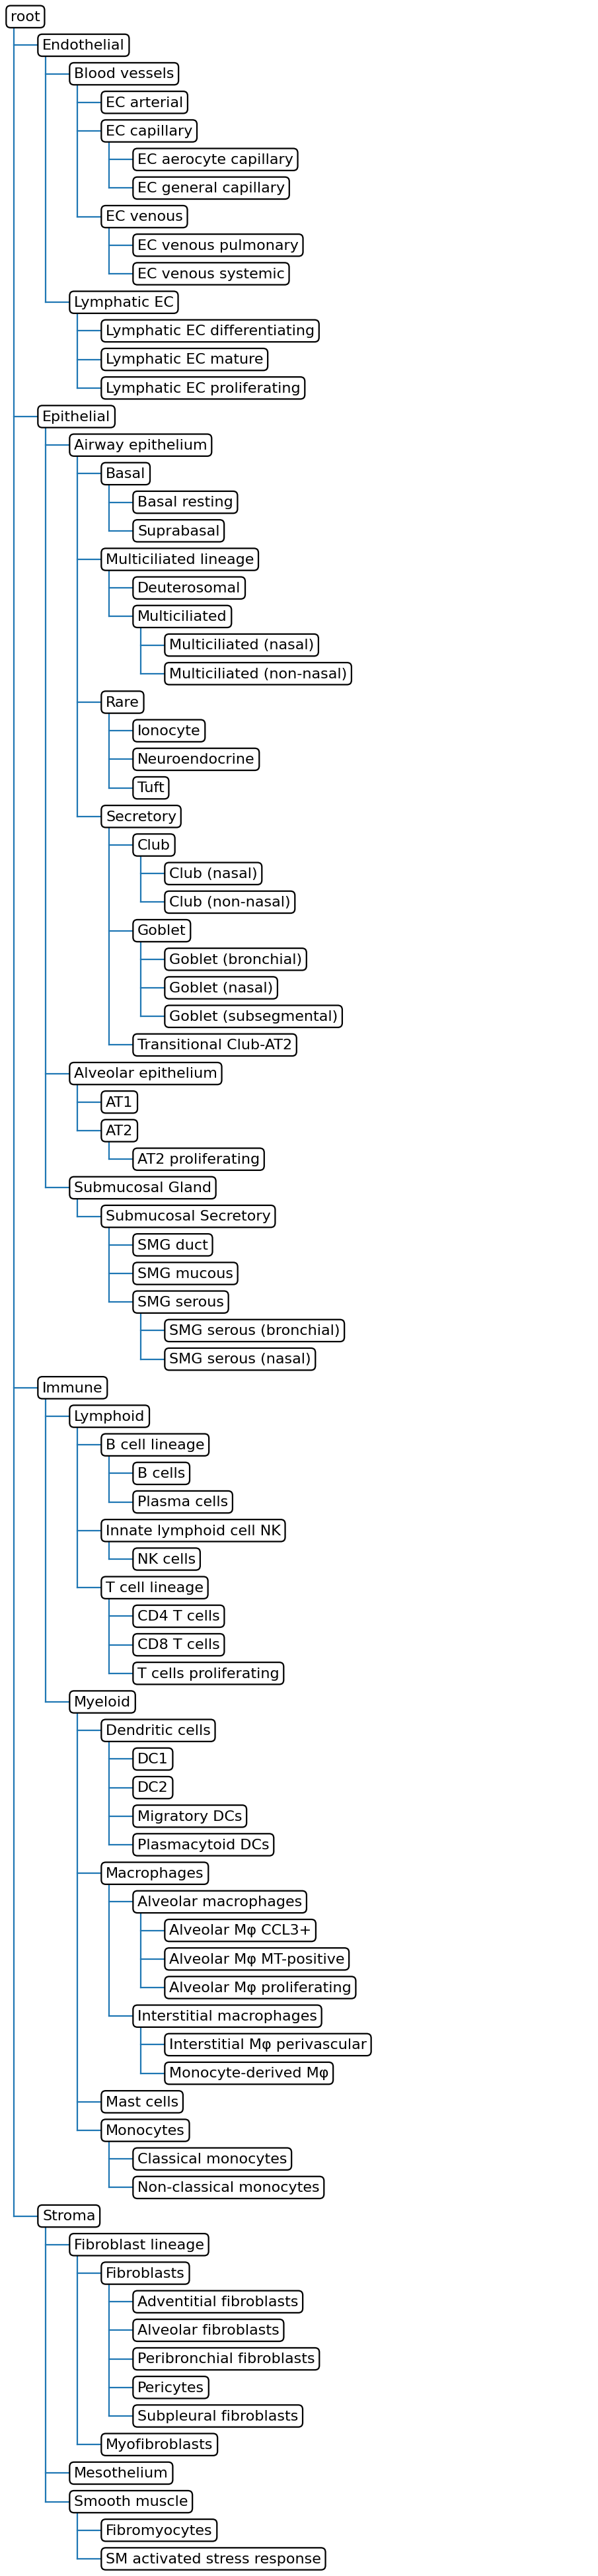


Adding dataset Query to the tree
These populations are missing from the tree: 
['2 Smooth muscle-Healthy']

Updated tree:


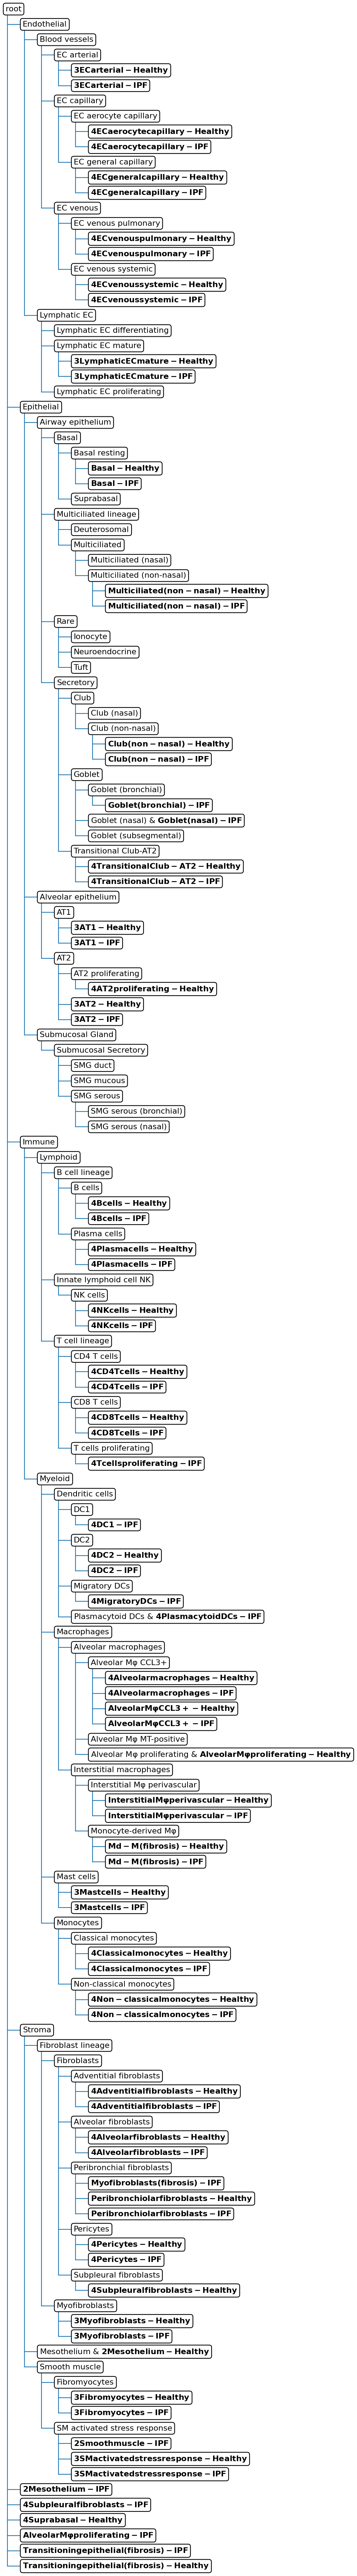

In [11]:
## Since the data contains >600.000 cells, this step can take a while to run (~1 hour)
HLCA_tree = scHPL.learn.learn_tree(LCA_IPF, 
                                     batch_key = 'batch',
                                     batch_order = ['Query'],
                                     cell_type_key = 'ct-batch',
                                     tree = HLCA_tree,
                                     retrain = False, useRE=True,
                                     batch_added = ['Reference']
                                    )


## Predict cell type labels 

In this part, we will show how to detect a subtype. First, we use the original tree to predict the labels of the query data.

In [12]:
file_to_read = open("tree_HCLA_FAISS_withRE.pickle", "rb")
HLCA_ref = pickle.load(file_to_read)
file_to_read.close()

y_pred = scHPL.predict.predict_labels(emb_ipf.X, 
               tree = HLCA_ref, 
               threshold = 0.5)

emb_ipf.obs['scHPL_pred'] = y_pred


Here, we will zoom in on the macrophages to see how they are predicted. Since, we're also interested in marker genes, we need the count data. The count data for the reference can be downloaded [here](https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293). 

In [13]:
data_LCA = sc.read_h5ad('local.h5ad')
data_LCA.var_names = np.asarray(data_LCA.var['feature_name'], dtype=str)

We normalize the IPF data

In [14]:
sc.pp.normalize_total(data_IPF)
sc.pp.log1p(data_IPF)

Concatenate the data

In [15]:
data_all = sc.concat([data_LCA, data_IPF])
data_all

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 646487 × 1897
    obs: 'sample', 'study', 'subject_ID', 'smoking_status', 'BMI', 'condition', 'sample_type', 'dataset', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'sex', 'ethnicity'
    obsm: 'X_scanvi_emb'

Prepare the metadata

In [23]:
data_all.obs['ann_level_3'] = data_LCA.obs.ann_level_3
data_all.obs['ann_finest_level'] = data_LCA.obs.ann_finest_level
data_all.obs['anno_final'] = data_IPF.obs.anno_final
data_all.obs['scHPL_pred'] = data_IPF.obs.scHPL_pred
data_all.obs['condition'] = data_IPF.obs.condition

Select the macrophages

In [24]:
idx_macro = ((data_all.obs['ann_level_3'] == 'Macrophages') | 
             np.isin(data_all.obs.anno_final, ['4_Alveolar macrophages', 'Alveolar Mφ CCL3+',
                                               'Alveolar Mφ proliferating',
                                                'Interstitial Mφ perivascular', 'Md-M (fibrosis)']))
data_macro = data_all[idx_macro]
data_macro

View of AnnData object with n_obs × n_vars = 117425 × 1897
    obs: 'sample', 'study', 'subject_ID', 'smoking_status', 'BMI', 'condition', 'sample_type', 'dataset', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'sex', 'ethnicity', 'ann_level_3', 'anno_final', 'scHPL_pred', 'ann_finest_level'
    obsm: 'X_scanvi_emb'

treeArches contains three types of rejection options (based on the distance, posterior probability and the reconstruction error). Here, we will rename these different types all to 'Rejected'.

In [25]:
idx_rej = ((data_macro.obs['scHPL_pred'] == 'Rejection (dist)') | (data_macro.obs['scHPL_pred'] == 'Rejected (RE)'))
data_macro.obs['scHPL_pred'] = data_macro.obs['scHPL_pred'].cat.add_categories('Rejected')
data_macro.obs['scHPL_pred'].values[idx_rej] = 'Rejected'

/tmp/ipykernel_2427513/617128616.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_macro.obs['scHPL_pred'] = data_macro.obs['scHPL_pred'].cat.add_categories('Rejected')


Here, we visualize the predictions for the IPF and healthy data separately using a Sankey diagram. The python function can be found [here](https://github.com/lcmmichielsen/treeArches-reproducibility/blob/main/Figure3-HLCA%20diseased/sankey.py). An alternative would be to visualize the predictions using `scHPL.evaluate.heatmap()` (see the treeArches basic tutorial).

In the Sankey plot, we notice that many of the Md-M fibrosis IPF cells are rejected, but that this is not the case for the healthy cells.

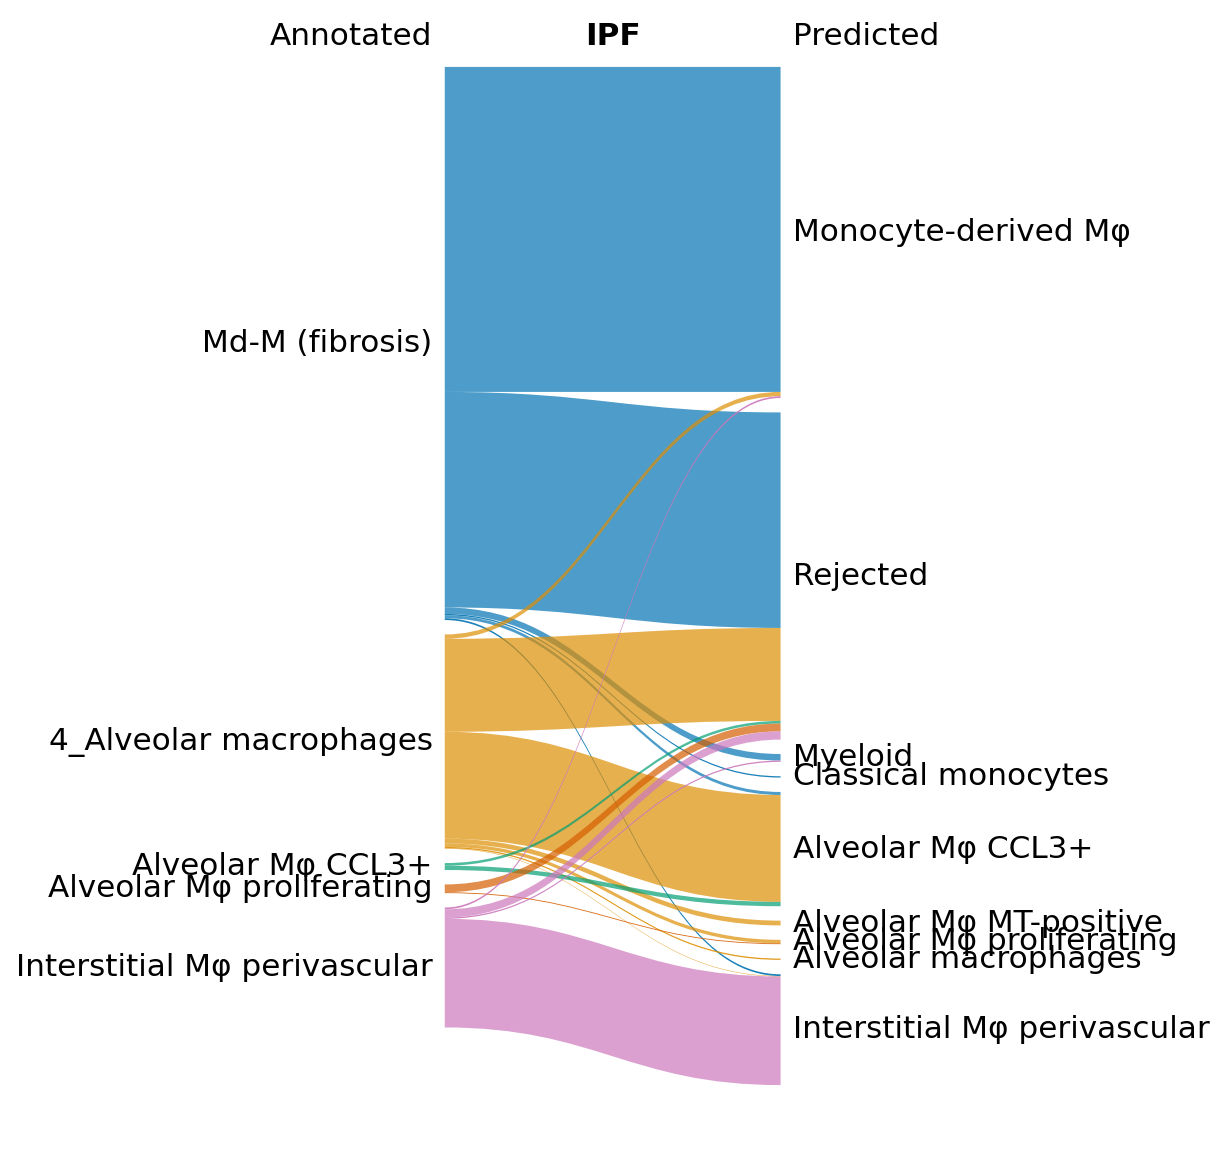

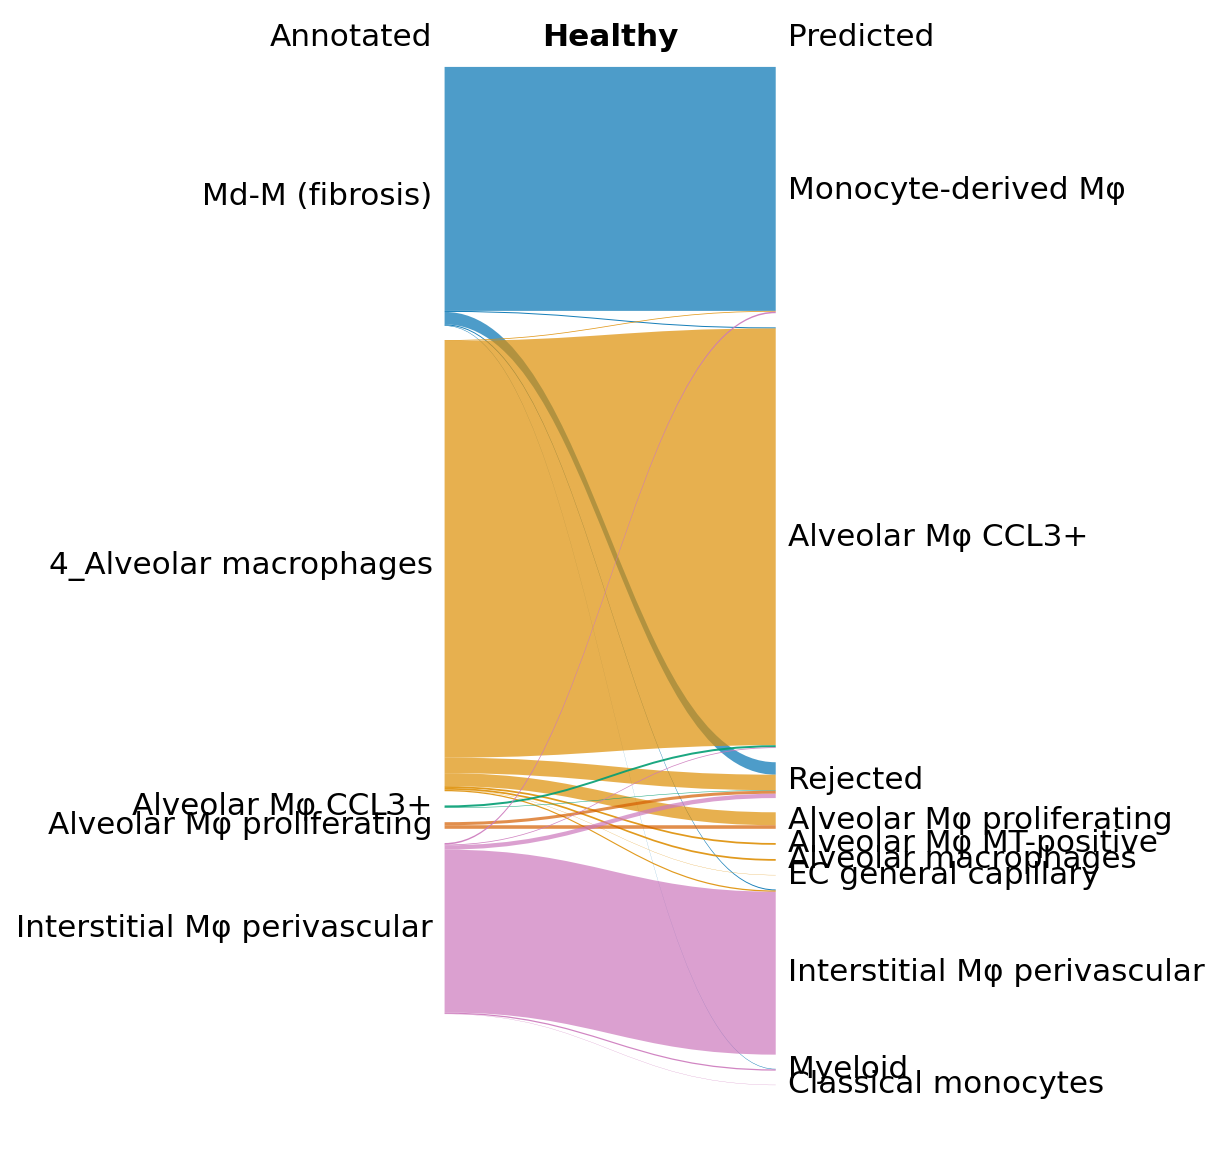

In [26]:
import sankey

idx1 = (data_macro.obs.study == 'Sheppard_2020') & (data_macro.obs.condition == 'IPF')
idx2 = (data_macro.obs.study == 'Sheppard_2020') & (data_macro.obs.condition == 'Healthy')

x = sankey.sankey( data_macro.obs['anno_final'][idx1],
                  data_macro.obs['scHPL_pred'][idx1], save=True, 
                  name_file='sankey_IPF', title="IPF", title_left="Annotated",
                  title_right="Predicted", alpha=0.7,
                  left_order=['Md-M (fibrosis)',
                             '4_Alveolar macrophages',
                              'Alveolar Mφ CCL3+',
                              'Alveolar Mφ MT-positive',
                              'Alveolar Mφ proliferating',
                              'Interstitial Mφ perivascular'
                             ], fontsize='medium')

x = sankey.sankey( data_macro.obs['anno_final'][idx2],
                  data_macro.obs['scHPL_pred'][idx2], save=True, 
                  name_file='sankey_NML', title="Healthy", title_left="Annotated",
                  title_right="Predicted", alpha=0.7,
                  left_order=['Md-M (fibrosis)',
                             '4_Alveolar macrophages',
                              'Alveolar Mφ CCL3+',
                              'Alveolar Mφ MT-positive',
                              'Alveolar Mφ proliferating',
                              'Interstitial Mφ perivascular'
                             ], fontsize='medium')

Next, we show how to verify the results by doing some downstream analysis. We split the Md-M fibrosis IPF cells in two groups: the rejected and not rejected cells, and we find differentially expression genes between the two.

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


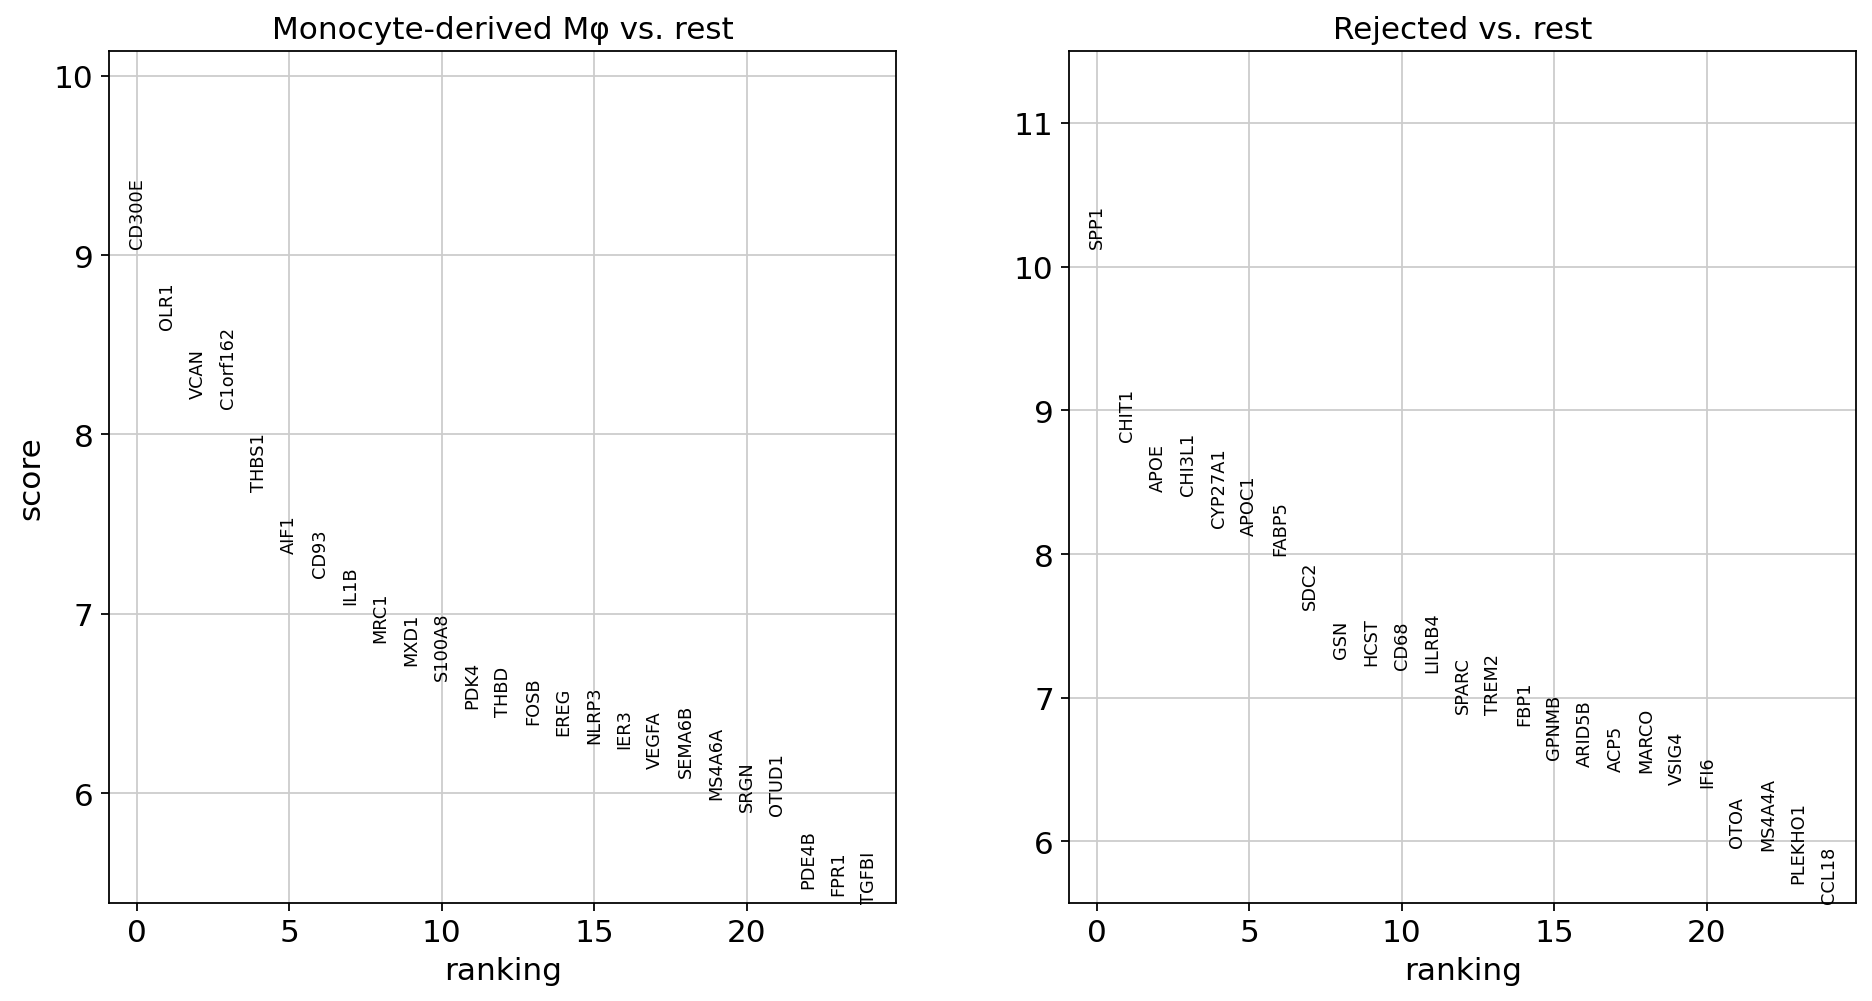

In [27]:
### Do DE
# Group 1: anno_final = Md-M (fibrosis), scHPL_pred = Monocyte-derived macro, condition=IPF
# Group 2: anno_final = Md-M (fibrosis), scHPL_pred = Rejected, condition=IPF
MdM = (data_macro.obs.condition == 'IPF') & (data_macro.obs.anno_final == 'Md-M (fibrosis)') & ((data_macro.obs.scHPL_pred == 'Rejected') | (data_macro.obs.scHPL_pred == 'Monocyte-derived Mφ'))
data_MdM = data_macro[MdM]

sc.pp.normalize_total(data_MdM)
sc.pp.log1p(data_MdM)

sc.tl.rank_genes_groups(data_MdM, 'scHPL_pred', method='t-test')
sc.pl.rank_genes_groups(data_MdM, n_genes=25, sharey=False)


In [28]:
data_macro.obs['ann_toplot'] = np.char.add(np.array(data_macro.obs.ann_finest_level, dtype=str),'-Reference')
data_macro.obs.ann_toplot[data_macro.obs.study == 'Sheppard_2020'] = np.char.add(np.char.add(np.array(data_macro.obs.anno_final, dtype=str), '-'), np.array(data_macro.obs.condition, dtype=str))
idx = (data_macro.obs.ann_toplot == 'Md-M (fibrosis)-IPF') & (data_macro.obs.scHPL_pred == 'Rejected')
data_macro.obs['ann_toplot'][idx] = 'Md-M (fibrosis)-IPF-(Rejected)'

/tmp/ipykernel_2427513/3849917173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_macro.obs.ann_toplot[data_macro.obs.study == 'Sheppard_2020'] = np.char.add(np.char.add(np.array(data_macro.obs.anno_final, dtype=str), '-'), np.array(data_macro.obs.condition, dtype=str))
/tmp/ipykernel_2427513/3849917173.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_macro.obs['ann_toplot'][idx] = 'Md-M (fibrosis)-IPF-(Rejected)'


When we visualize this marker gene, we see that it is only expressed in the Md-M IPF rejected cells. According to literature, SPP1 is known to be a hallmark for IPF pathogenesis [1](https://doi.org/10.1371/journal.pone.0248889), [2](https://erj.ersjournals.com/content/54/2/1802441.long).

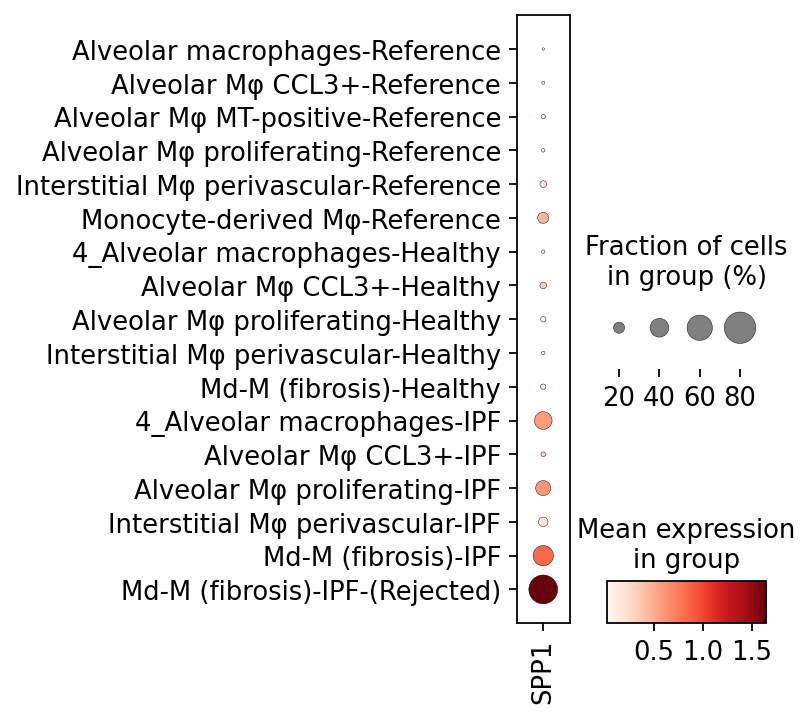

In [29]:
sc.pl.dotplot(data_macro, ['SPP1'], groupby='ann_toplot',
             categories_order=[
                 'Alveolar macrophages-Reference',
                 'Alveolar Mφ CCL3+-Reference',
                 'Alveolar Mφ MT-positive-Reference',
                 'Alveolar Mφ proliferating-Reference',
                 'Interstitial Mφ perivascular-Reference',
                 'Monocyte-derived Mφ-Reference',
                 
                 '4_Alveolar macrophages-Healthy',
                 'Alveolar Mφ CCL3+-Healthy', 
                 'Alveolar Mφ proliferating-Healthy',
                 'Interstitial Mφ perivascular-Healthy',
                 'Md-M (fibrosis)-Healthy',
                 
                 '4_Alveolar macrophages-IPF',
                 'Alveolar Mφ CCL3+-IPF',
                 'Alveolar Mφ proliferating-IPF',
                 'Interstitial Mφ perivascular-IPF',
                 'Md-M (fibrosis)-IPF',
                 'Md-M (fibrosis)-IPF-(Rejected)'
             ], figsize=(2,5), save='_IPF_SPP1.pdf')
